# DINOv2 Exploration

This notebook is used for exploring the DINOv2 model, including loading the model, running predictions, and visualizing results.

In [1]:
import os
os.chdir('..')

from src.models.dinov2_model import Dinov2Model
from src.utils.visualization import display_image, open_image

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset

from tqdm import tqdm

# Initialize the DINOv2 model
dinov2_model = Dinov2Model()
dinov2_model.load_model()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
dinov2_model.to(device)

/users/eleves-b/2024/mattia.martino/env_cv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


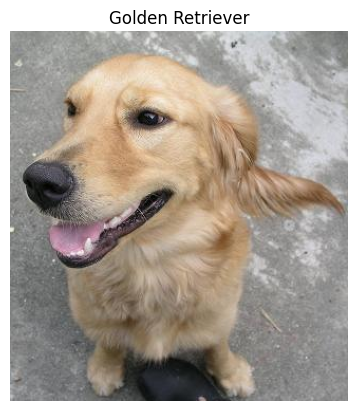

In [2]:
# Dispaly an image
input_image_path = 'dogs_data/Images/n02099601-golden_retriever/n02099601_6099.jpg'  # Use the already defined path
image = open_image(input_image_path)
display_image(image, title='Golden Retriever')

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(root='dogs_data/Images/', transform=transform)
dataloader = DataLoader(dataset, batch_size=256, shuffle=False)

In [4]:
dinov2_model.eval()

In [5]:
target_breed = "n02099601-golden_retriever"
index_breed = dataset.class_to_idx[target_breed]

In [6]:
target_indices = [i for i, (_, label) in enumerate(dataset) if label == index_breed]

# Create a subset for the target breed
breed_subset = Subset(dataset, target_indices)

# Now you can create a DataLoader for this subset
breed_loader = DataLoader(breed_subset, batch_size=256, shuffle=False)

In [7]:
features = []
labels = []
for imgs, target in breed_loader:

    imgs, target = imgs.to(device), target.to(device)

    feats = dinov2_model.predict(imgs)

    feats = feats[0].cpu()
    features.append(feats)
    labels.extend(target.cpu().numpy())

features = torch.cat(features, dim=0)

Average cosine similarity between features: 0.4099


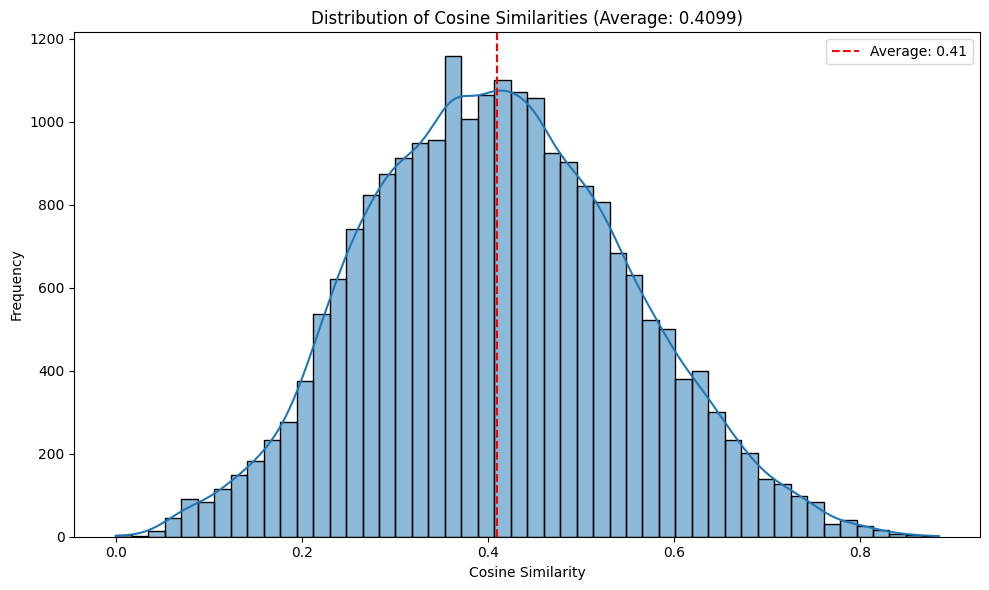

In [11]:
features_avg = features.mean(dim=1)

normalized_features = F.normalize(features_avg, p=2, dim=1)

n = normalized_features.shape[0]
similarities = torch.mm(normalized_features, normalized_features.t())

mask = ~torch.eye(n, dtype=bool, device=similarities.device)
similarities_no_diagonal = similarities[mask]

avg_similarity = similarities_no_diagonal.mean().item()
print(f"Average cosine similarity between features: {avg_similarity:.4f}")

plt.figure(figsize=(10, 6))
sns.histplot(similarities_no_diagonal.cpu().numpy(), bins=50, kde=True)
plt.title(f'Distribution of Cosine Similarities (Average: {avg_similarity:.4f})')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.axvline(x=avg_similarity, color='r', linestyle='--', label=f'Average: {avg_similarity:.2f}')
plt.legend()
plt.tight_layout()

In [6]:
features = []
labels = []
for imgs, target in tqdm(dataloader):

    imgs, target = imgs.to(device), target.to(device)

    feats = dinov2_model.predict(imgs)

    feats = feats[0].cpu()
    features.append(feats)
    labels.extend(target.cpu().numpy())

features = torch.cat(features, dim=0)

100%|██████████| 81/81 [01:11<00:00,  1.14it/s]


In [8]:
features_avg = features.mean(dim=1)

normalized_features = F.normalize(features_avg, p=2, dim=1)

n = normalized_features.shape[0]
similarities = torch.mm(normalized_features, normalized_features.t())

mask = ~torch.eye(n, dtype=bool, device=similarities.device)
similarities_no_diagonal = similarities[mask]

avg_similarity = similarities_no_diagonal.mean().item()
print(f"Average cosine similarity between features: {avg_similarity:.4f}")

Average cosine similarity between features: 0.2943


KeyboardInterrupt: 

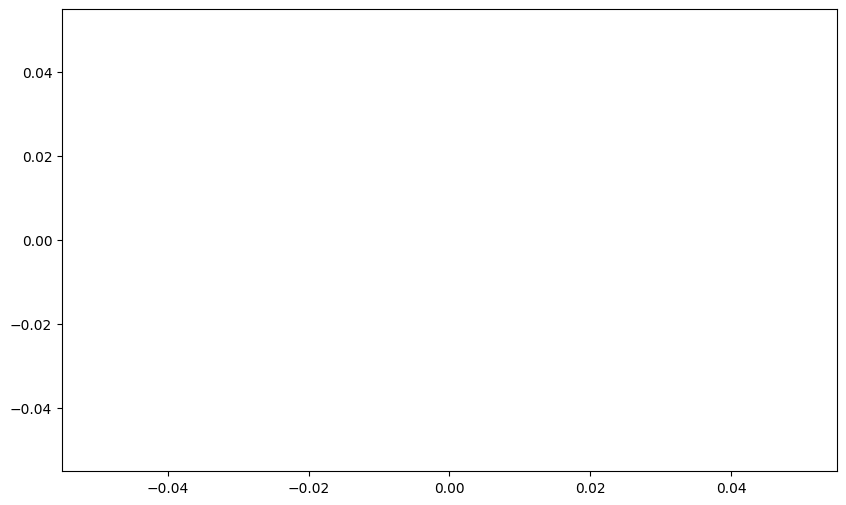

In [ ]:

plt.figure(figsize=(10, 6))
sns.histplot(similarities_no_diagonal.cpu().numpy(), bins=50, kde=True)
plt.title(f'Distribution of Cosine Similarities (Average: {avg_similarity:.4f})')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.axvline(x=avg_similarity, color='r', linestyle='--', label=f'Average: {avg_similarity:.2f}')
plt.legend()
plt.tight_layout()

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.decomposition import PCA

# Convert features to numpy array
features_np = features_avg.numpy()
labels_np = np.array(labels)

# Get unique classes
unique_classes = np.unique(labels_np)
n_classes = len(unique_classes)

# Map class indices to class names
class_id_to_name = {v: k for k, v in dataset.class_to_idx.items()}
class_names = [class_id_to_name[cls] for cls in unique_classes]

# Compute centroids for each class
centroids = np.zeros((n_classes, features_np.shape[1]))
for i, cls in enumerate(unique_classes):
    class_indices = np.where(labels_np == cls)[0]
    centroids[i] = np.mean(features_np[class_indices], axis=0)

# Calculate pairwise distances
cosine_dist = cosine_distances(centroids)
euclidean_dist = euclidean_distances(centroids)

# Create DataFrame for distances
distance_df = pd.DataFrame(
    euclidean_dist,
    index=[name.split('--')[-1] for name in class_names],
    columns=[name.split('--')[-1] for name in class_names]
)

# Apply PCA for visualization
pca = PCA(n_components=2)
centroids_2d = pca.fit_transform(centroids)
explained_variance = pca.explained_variance_ratio_

# Create DataFrame for PCA results
pca_df = pd.DataFrame({
    'PC1': centroids_2d[:, 0],
    'PC2': centroids_2d[:, 1],
    'Breed': [name.split('--')[-1] for name in class_names]
})


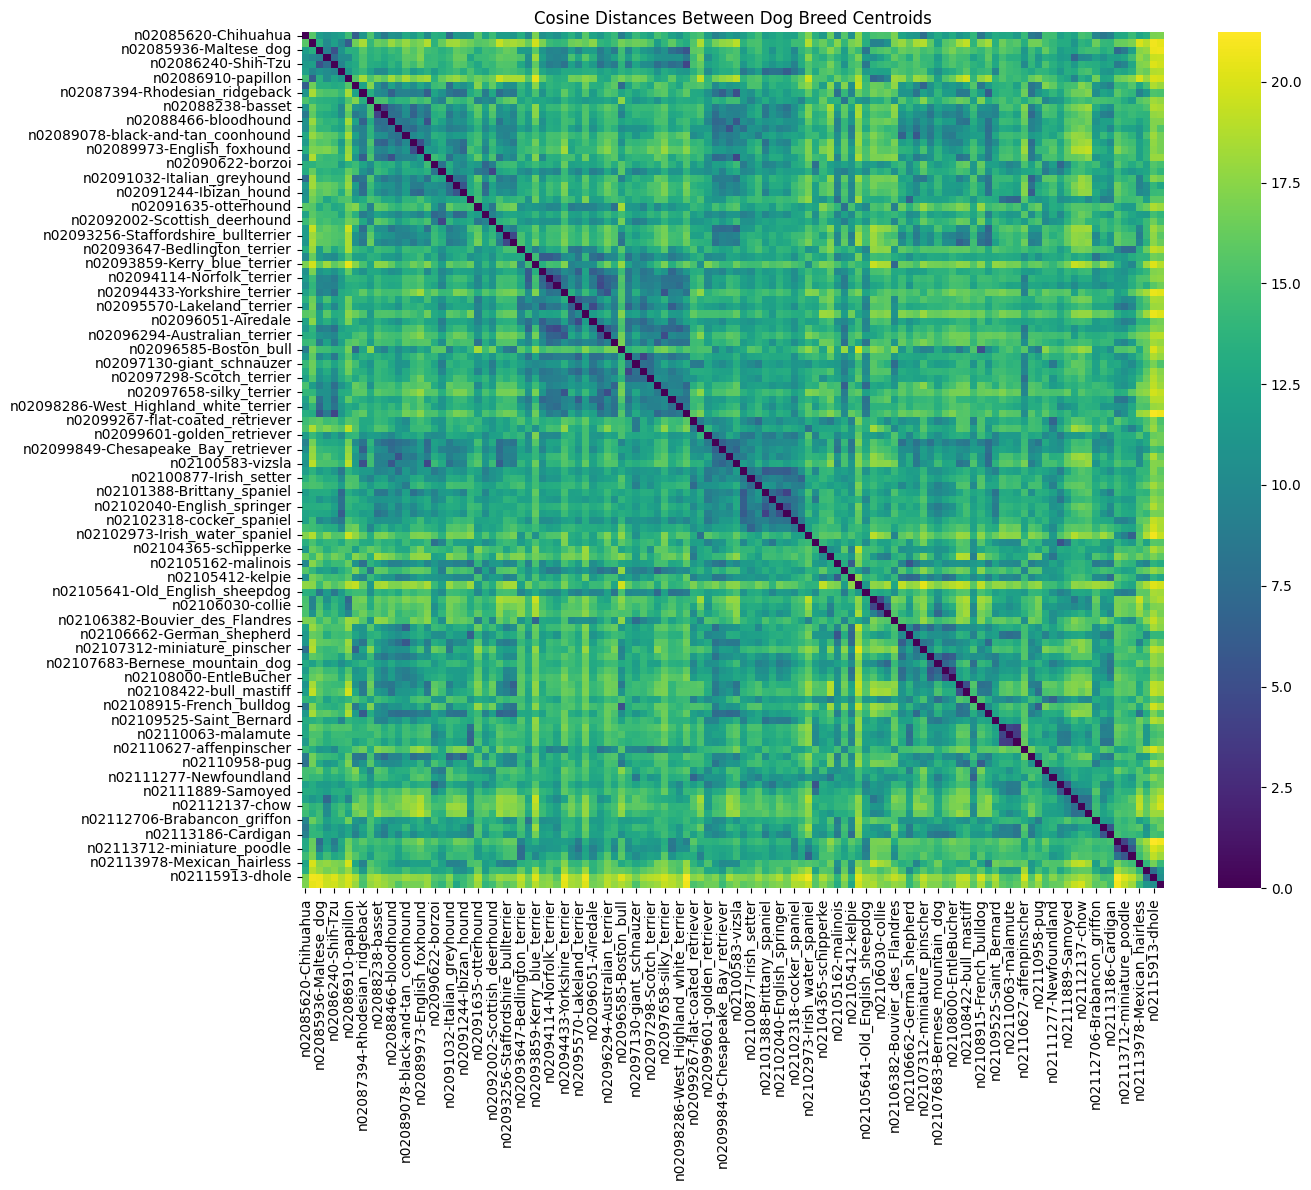

In [10]:
# Display heatmap with subset selection if needed
plt.figure(figsize=(14, 12))

sns.heatmap(distance_df, cmap='viridis')
plt.title('Cosine Distances Between Dog Breed Centroids')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [12]:
distance_df.values[np.tril_indices_from(distance_df)] = np.nan

# Convert to long format and sort by distance
sorted_distances = distance_df.stack().reset_index()
sorted_distances.columns = ['Breed1', 'Breed2', 'Distance']
sorted_distances = sorted_distances.sort_values(by='Distance')

import ace_tools_open as tools
tools.display_dataframe_to_user(name="Sorted Cosine Distances", dataframe=sorted_distances)

Sorted Cosine Distances
